# Troubleshooting the network aggregations

Sam Maurer, July 2018 - Python 3.6

In [1]:
import orca
import pandana as pdna
import pandas as pd
from urbansim.utils import misc, networks
import os; os.chdir('..')
import warnings;warnings.simplefilter('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### Look at the network

In [3]:
d = 'data/'
nodessmall = pd.read_csv(d + 'bay_area_tertiary_strongly_nodes.csv')
edgessmall = pd.read_csv(d + 'bay_area_tertiary_strongly_edges.csv')

In [4]:
print(len(nodessmall))
nodessmall.head(3)

30826


,osmid,x,y,ref,highway
0,281266,-122.302578,37.560184,414B,motorway_junction
1,302878,-122.059974,37.348484,NaN,NaN
2,302883,-122.059750,37.337687,19A,motorway_junction


In [5]:
print(len(edgessmall))
edgessmall.head(3)

65524


,uniqueid,u,v,key,oneway,highway,name,length,lanes,width,est_width,maxspeed,access,service,bridge,tunnel,area,junction,osmid,ref
0,0,309330024,253297204,0,True,motorway,Bayshore Freeway,320.849,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256787725,US 101
1,1,247385811,247385812,0,True,primary,Wolfe Road,395.862,"['4', '3']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[158248728, 393494148, 413296620]",NaN
2,2,247385811,65553953,0,False,secondary,East Homestead Road,363.617,5,NaN,NaN,35 mph,NaN,NaN,NaN,NaN,NaN,NaN,"[415833672, 506531251, 415833636, 415833670]",NaN


In [6]:
nodessmall[['osmid']].describe()

,osmid
count,3.082600e+04
mean,1.092442e+09
std,1.536415e+09
min,2.812660e+05
25%,6.539825e+07
50%,2.816185e+08
75%,1.664390e+09
max,5.461053e+09


In [7]:
edgessmall[['u','v','length']].describe()

,u,v,length
count,6.552400e+04,6.552400e+04,65524.000000
mean,1.008384e+09,1.002995e+09,479.966123
std,1.505452e+09,1.499072e+09,1123.813497
min,2.812660e+05,2.812660e+05,0.208000
25%,6.533394e+07,6.533409e+07,48.300750
50%,2.576782e+08,2.576985e+08,173.583000
75%,1.241512e+09,1.230249e+09,482.175000
max,5.461053e+09,5.461053e+09,30915.501000


### Look at parcels

In [14]:
# Code from datasources.py

@orca.table(cache=True)
def parcels():
#    df = pd.read_hdf(d + 'bayarea_ual.h5', 'parcels')
    df = pd.read_csv(d + 'mtc_data_platform_format_7-6-18/' + 'parcel_attr.csv')
    return df

@orca.table(cache=True)
def buildings():
#    df = pd.read_hdf(d + 'bayarea_ual.h5', 'buildings')
    df = pd.read_csv(d + 'mtc_data_platform_format_7-6-18/' + 'buildings_v2.csv')
    return df

orca.broadcast('parcels', 'buildings', cast_index=True, onto_on='parcel_id')

# Use broadcasts to add some virtual columns, to make analysis easier

@orca.column('buildings', 'county_id')
def county_id(parcels, buildings):
    return misc.reindex(parcels.county_id, buildings.parcel_id)

In [9]:
p = orca.get_table('parcels').to_frame()

In [10]:
print(len(p))
p.head(3)

1956207


,primary_id,development_type_id,land_value,acres,county_id,zone_id,proportion_undevelopable,tax_exempt_status,apn,parcel_id_local,geom_id,imputation_flag,x,y,shape_area,block_id,node_id
0,229116,1,0.0,3.360520,1,725,0.0,0,099 029001700,,10305106092872,_,-121.795620,37.655379,13599.555578,60014511022061,53091636
1,244166,1,0.0,1.294423,1,715,0.0,0,099B540210200,,11107351665227,_,-121.713004,37.717277,5238.347696,60014511011025,53059159
2,202378,25,6036500.0,14.993605,1,820,0.0,1,085A643106000,,11030175960628,merged,-122.014199,37.655260,60677.019451,60014351031029,1852532916


In [11]:
b = orca.get_table('buildings').to_frame()
print(len(b))
b.head(3)

1824229


,building_id,parcel_id,development_type_id,improvement_value,residential_units,residential_sqft,sqft_per_unit,non_residential_sqft,building_sqft,nonres_rent_per_sqft,res_price_per_sqft,stories,year_built,redfin_sale_price,redfin_sale_year,redfin_home_type,costar_property_type,costar_rent,building_type_id
0,1.0,742974.0,1.0,0.00,1.0,2029.0,2029.42425,0.0,2029.42425,0.0,302.769751,1.0,1945.0,NaN,NaN,NaN,NaN,NaN,1.0
1,2.0,744961.0,1.0,0.00,1.0,2029.0,2029.42425,0.0,2029.42425,0.0,254.429279,1.0,1965.0,NaN,NaN,NaN,NaN,NaN,1.0
2,3.0,1442641.0,1.0,53262.87,1.0,1568.0,1568.00000,0.0,1568.00000,0.0,183.474166,1.0,1964.0,NaN,NaN,NaN,NaN,NaN,1.0


### Load network into pandana

In [11]:
# Code from Paul in Slack

@orca.injectable('netsmall', cache=True)
def build_networksmall():
    nodessmall = pd.read_csv(d + 'bay_area_tertiary_strongly_nodes.csv').set_index('osmid')
    edgessmall = pd.read_csv(d + 'bay_area_tertiary_strongly_edges.csv')
    netsmall = pdna.Network(nodessmall.x, nodessmall.y, edgessmall.u, \
        edgessmall.v, edgessmall[['length']], twoway=False)
    netsmall.precompute(5000)
    return netsmall

parcels = orca.get_table('parcels').to_frame(columns=['x','y'])
idssmall_parcel = orca.get_injectable('netsmall').get_node_ids(parcels.x, parcels.y)
orca.add_column('parcels', 'node_id_small', idssmall_parcel, cache=False)
orca.broadcast('nodessmall', 'parcels', cast_index=True, onto_on='node_id_small')

# Added from models.py

@orca.column('buildings', 'node_id_small')
def node_id(parcels, buildings):
    return misc.reindex(parcels.node_id_small, buildings.parcel_id)

In [12]:
orca.get_table('parcels').to_frame().node_id_small.describe()

count    1.956207e+06
mean     7.947319e+08
std      1.402735e+09
min      2.812660e+05
25%      5.787896e+07
50%      6.550126e+07
75%      6.256488e+08
max      5.458527e+09
Name: node_id_small, dtype: float64

In [13]:
# This is what network_test.yaml looks like

'''
model_type: networks
node_col: node_id_small
variable_definitions:

  - name: residential_units_500
    dataframe: buildings
    varname: residential_units
    radius: 500
'''

'\nmodel_type: networks\nnode_col: node_id_small\nvariable_definitions:\n\n  - name: residential_units_500\n    dataframe: buildings\n    varname: residential_units\n    radius: 500\n'

In [14]:
# Code adapted from models.py

@orca.step()
def network_aggregations_small(netsmall):
    nodessmall = networks.from_yaml(netsmall, 'network_test.yaml')
    orca.add_table('nodessmall', nodessmall)

### Look at aggregations

In [15]:
orca.run(['network_aggregations_small'])

Running step 'network_aggregations_small'
Computing accessibility variables
Computing residential_units_500
Removed 76038 rows because they contain missing values
Time to execute step 'network_aggregations_small': 6.06 s
Total time to execute iteration 1 with iteration value None: 6.06 s


In [16]:
orca.get_table('nodessmall').to_frame().head(3)

,residential_units_500
osmid,
281266,50.702003
302878,172.000000
302883,13.258960


In [17]:
df = orca.get_table('parcels').to_frame().join(orca.get_table('nodessmall').to_frame(), on='node_id_small')

df.head(3)

,primary_id,development_type_id,land_value,acres,county_id,zone_id,proportion_undevelopable,tax_exempt_status,apn,parcel_id_local,geom_id,imputation_flag,x,y,shape_area,block_id,node_id,node_id_small,residential_units_500
0,229116,1,0.0,3.360520,1,725,0.0,0,099 029001700,,10305106092872,_,-121.795620,37.655379,13599.555578,60014511022061,53091636,53103254,213.788589
1,244166,1,0.0,1.294423,1,715,0.0,0,099B540210200,,11107351665227,_,-121.713004,37.717277,5238.347696,60014511011025,53059159,53026359,277.000000
2,202378,25,6036500.0,14.993605,1,820,0.0,1,085A643106000,,11030175960628,merged,-122.014199,37.655260,60677.019451,60014351031029,1852532916,1706630465,852.669739


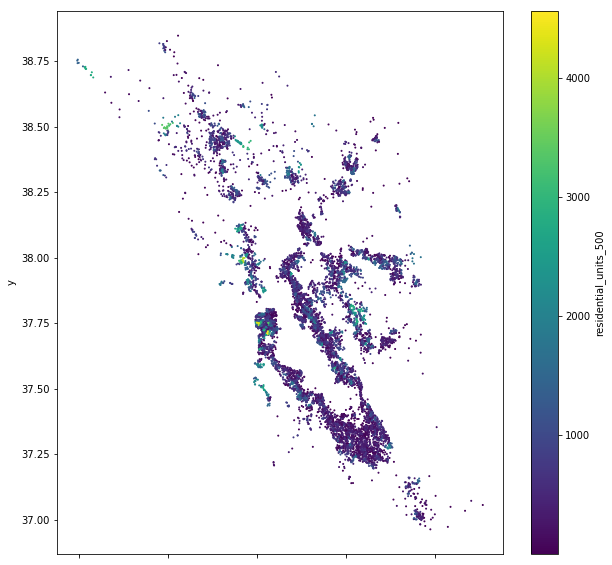

In [18]:
data = df.sample(10000)
data.plot.scatter('x', 'y', c='residential_units_500', s=1, cmap='viridis', figsize=(10,10))

#### That looks wrong. What about the raw units in the buildings table?

In [22]:
df = orca.get_table('buildings').to_frame()\
        .join(orca.get_table('parcels').to_frame()[['x','y']], on='parcel_id')

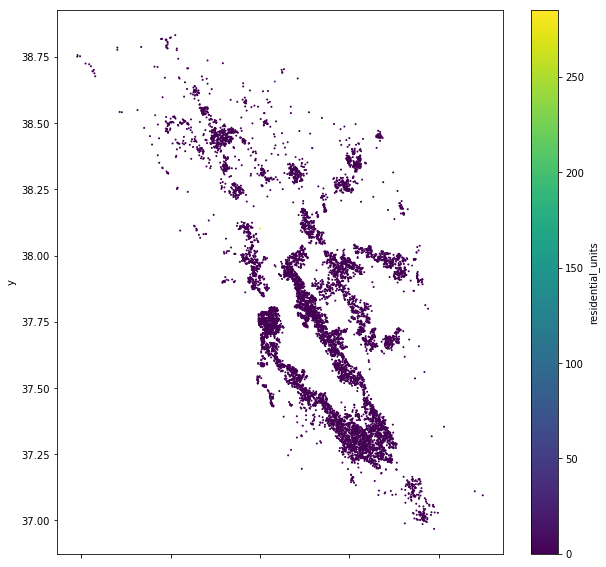

In [23]:
data = df.sample(10000)
data.plot.scatter('x', 'y', c='residential_units', s=1, cmap='viridis', figsize=(10,10))

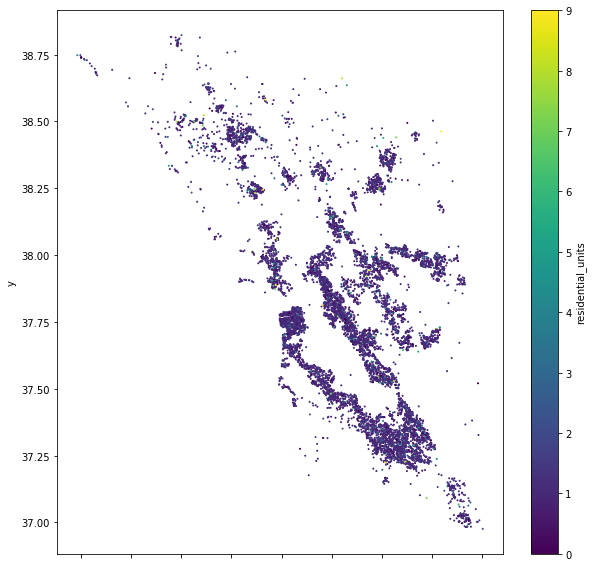

In [24]:
# Limit to small buildings to see if there's more variety
data = df.loc[df.residential_units < 10].sample(10000)
data.plot.scatter('x', 'y', c='residential_units', s=1, cmap='viridis', figsize=(10,10))

In [25]:
b = orca.get_table('buildings').to_frame()
b.residential_units.describe()

count    1.824229e+06
mean     1.534000e+00
std      6.137263e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.912000e+03
Name: residential_units, dtype: float64

In [15]:
b.residential_units.value_counts().head(5)

1.0    1418200
2.0     179620
0.0     108755
3.0      42948
4.0      23777
Name: residential_units, dtype: int64

In [16]:
b.loc[b.county_id == 75].residential_units.describe()

count    135964.000000
mean          1.589156
std           7.402502
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1746.000000
Name: residential_units, dtype: float64

In [19]:
print(len(b.loc[b.county_id == 75]))
b.loc[b.county_id == 75].residential_units.value_counts().head(5)

135964


1.0    106526
2.0     12589
0.0      7341
3.0      3344
4.0      1935
Name: residential_units, dtype: int64

#### The overall distribution of unit counts isn't as weird as i originally thought (it's reasonable for the majority of the regeion to be single-family), but even in the city of San Francisco it seems to be about 75% single-family, which is probably wrong.

### Load some more data

In [26]:
# From datasources.py

@orca.table(cache=True)
def units():
    #z = zipfile.ZipFile(d + 'units_w_tenure.zip')
    #df = pd.read_csv(z.open('units_w_tenure.csv'))
    df = pd.read_csv(d + 'mtc_data_platform_format_7-6-18/' + 'units_v2.csv')
    df.index.name = 'unit_id'  # first column in CSV is unnamed
    return df

@orca.table(cache=True)
def households():
#    z = zipfile.ZipFile(d + 'synthpop_w_units.zip')
#    df = pd.read_csv(z.open('households_w_units.csv'))
    df = pd.read_csv(d + 'mtc_data_platform_format_7-6-18/' + 'households_v2.csv')
    return df

In [27]:
orca.get_table('units').to_frame().head(3)

,unit_id,building_id,num_units,tenure,unit_num,unit_residential_price,unit_residential_rent
unit_id,,,,,,,
0,0,1,1,1,0,0,0
1,1,9,1,1,0,0,0
2,2,13,1,2,0,0,0


In [28]:
orca.get_table('households').to_frame().head(3)

,household_id,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,...,county,tract,block_group,children,tenure,recent_mover,block_group_id,single_family,unit_id,building_id
0,0,2010000487191,1,6.0,1.0,85000.0,1,no,47,1.0,...,85,500901,1,0.0,2,0,60855009011,False,1711366,409174.0
1,1,2013000554587,1,9.0,1.0,27000.0,6,no,52,1.0,...,85,500901,1,0.0,2,0,60855009011,False,1711818,1579443.0
2,2,2011001140920,2,2.0,1.0,6000.0,6,no,60,1.0,...,85,500901,1,0.0,2,0,60855009011,True,1711727,1365639.0


In [31]:
# Try mapping income.

# To get xy onto households, first get parcel_id from the buildings table...

_df = orca.get_table('households').to_frame()\
        .join(orca.get_table('buildings').to_frame()[['parcel_id']], on='building_id')

# ...then get xy from the parcels table

df = _df.join(orca.get_table('parcels').to_frame()[['x','y']], on='parcel_id')

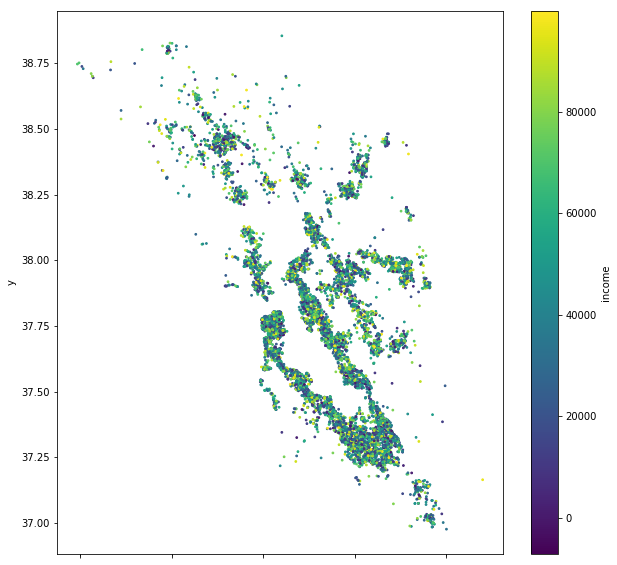

In [35]:
data = df.loc[df.income < 100000].sample(10000)
data.plot.scatter('x', 'y', c='income', s=3, cmap='viridis', figsize=(10,10))

#### Income looks quite evenly distributed, which would explain why the aggregations are as well

### Is the index on the households table wrong?

In [36]:
@orca.table(cache=True)
def households():
#    z = zipfile.ZipFile(d + 'synthpop_w_units.zip')
#    df = pd.read_csv(z.open('households_w_units.csv'))
    df = pd.read_csv(d + 'mtc_data_platform_format_7-6-18/' + 'households_v2.csv')
    df.index.name = 'household_id'  # ADDING THIS LINE
    return df

In [37]:
_df = orca.get_table('households').to_frame()\
        .join(orca.get_table('buildings').to_frame()[['parcel_id']], on='building_id')

df = _df.join(orca.get_table('parcels').to_frame()[['x','y']], on='parcel_id')

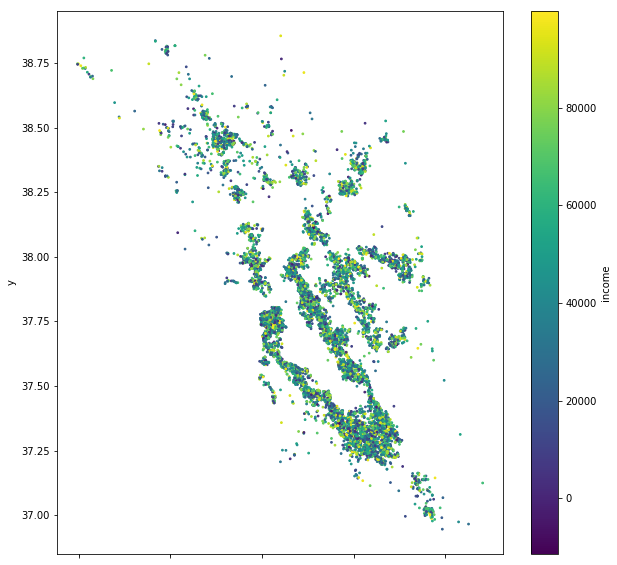

In [38]:
data = df.loc[df.income < 100000].sample(10000)
data.plot.scatter('x', 'y', c='income', s=3, cmap='viridis', figsize=(10,10))

#### We should probably set it, but I guess it wouldn't make a difference here anyway (it could only mess up links to finer-grained tables)